# Performance Management Feedback/Comment Quality Analysis

## Deep Learning Architecture built with Keras - 1D CNN + LSTM

In [34]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import accuracy_score

from sklearn.utils import resample
from gensim.models import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D,Bidirectional,SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dropout

from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl')

In [2]:
df = pd.read_excel('Comments_Final.xlsx',sheet_name='Sheet1',header=0,converters={"comments":str,"quality":str})
df.dropna(inplace=True)
df.dtypes
df.head()

,Associate ID,comments,quality
0,0.000020,Andrejs had really good Q1 2019. He reached al...,Ineffective
1,0.000321,Drishya is a good team player. She delivers he...,Effective
2,0.003042,Shown good improvement in accuracy as constant...,Effective
3,0.031727,Dharani did well on project delivery. Need to ...,Effective
4,0.031813,Should Improve Production Q1 Performance detai...,Ineffective


In [3]:
df.index = range(10405)
df['quality'] = df['quality'].replace({'effective':'Effective', 'Effective':'Effective'})

In [4]:
df.quality.value_counts()

Ineffective    7813
Effective      2592
Name: quality, dtype: int64

## Feature Engineering of Word Count

In [6]:
df['word_count'] = df['comments'].apply(lambda x: len(str(x).split()))

df.loc[df['word_count'] < 30, 'quality'] = "Ineffective"

In [7]:
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'

In [8]:
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

# Data Preprocessing & Text Cleaning.
    - Removing Trailing, Leading & Extra Spaces in between sentences
    - Removing Special Characters & Digits from text
    - Removing Stopwords

In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,#]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = text.lstrip()
    text = text.rstrip()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub(' ', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = re.sub(r'\d+', '', text)
    text = re.sub(r"\s+"," ",text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [10]:
df['comments'] = df['comments'].astype(str).apply(clean_text)

## Lemmatizing the text data

In [11]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens if len(word)>2 and (word not in STOPWORDS)] 
    return lemmas

df['comments'] = df['comments'].apply(lemmatize_word)

## Hyperparameters set

In [12]:
MAX_NB_WORDS = 20000
# Max number of words in each comment
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 300
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['comments'].values)

In [13]:
#import pickle

In [14]:
#with open('tokenizer.pickle', 'wb') as handle:
#    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11862 unique tokens.


## Tensor Matrix for Perf. Mgmt Comments

In [16]:
X = tokenizer.texts_to_sequences(df['comments'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH,padding='post',truncating='post')
print(X)
print('Shape of one feature tensor:', X.shape)

[[3706  205    2 ...    0    0    0]
 [6715    2    4 ...    0    0    0]
 [  49    2   22 ...    0    0    0]
 ...
 [   2    1   31 ...    0    0    0]
 [   3    1   15 ...    0    0    0]
 [   3  338   10 ...    0    0    0]]
Shape of one feature tensor: (10405, 300)


## Tensor Matrix for Comment Quality (Effective/Ineffective)

In [17]:
Y = pd.get_dummies(df['quality']).values
print(Y)
print('Shape of one label tensor:', Y.shape)

[[0 1]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
Shape of one label tensor: (10405, 2)


# Creating Word Embedding Matrix

In [18]:
nb_words = min(MAX_NB_WORDS, len(word_index))+1
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
embedding_matrix.shape

(11863, 300)

# Word Embedding Matrix

In [32]:
for (word, idx) in word_index.items():
    if word in word2vec.vocab and idx < MAX_NB_WORDS:
        embedding_matrix[idx] = word2vec.word_vec(word)
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.07568359  0.03369141 -0.06494141 ...  0.01202393  0.13574219
  -0.09130859]
 [ 0.04052734  0.0625     -0.01745605 ... -0.15625     0.00193024
  -0.06982422]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.26953125 -0.01300049  0.11328125 ... -0.37890625 -0.359375
  -0.19726562]
 [-0.26953125  0.02600098 -0.06982422 ...  0.00080109  0.01501465
   0.0480957 ]]


Null word embeddings: 5044


# Data Split into 70% Train, 20% Test and 10 % Validation

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8324, 300) (8324, 2)
(2081, 300) (2081, 2)


# 1D CNN + BiDirectional LSTM Model for Binary Text Classification

In [22]:
model = Sequential()

#We load this embedding matrix into an Embedding layer. Note that we set trainable=False to prevent the weights from being updated during training.
model.add(Embedding(len(embedding_matrix), EMBEDDING_DIM, weights=[embedding_matrix], 
                            input_length=MAX_SEQUENCE_LENGTH, trainable=False))
#While 2D CNNs are used for image and video processing, 1D CNNs are used for natural language processing (NLP)
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(300)))
model.add(Dropout(0.2))

model.add(Dense(2, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


# Model Summary and optimization parameters

In [23]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          3558900   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 300, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 150, 32)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 32)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600)               799200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

# Training Model here
    
     1) 5 Epochs
     2) Model Checkpoint - Save Best & Weights
     3) Early Stopping with Patience = 3

In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,min_delta=0.0001)
#model_checkpoint = ModelCheckpoint(]\ ',monitor='val_loss',save_best_only=True,save_weights_only=True)

hist = model.fit(X_train, Y_train, \Dee
        epochs=4, batch_size=64, shuffle=True, \
        callbacks=[early_stop])
accr = model.evaluate(X_test,Y_test)
print('\nTest set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Instructions for updating:
Use tf.cast instead.
Train on 7491 samples, validate on 833 samples
Epoch 1/4
7491/7491 [==============================] - 97s 13ms/step - loss: 0.4383 - acc: 0.7967 - val_loss: 0.4166 - val_acc: 0.7713
Epoch 2/4
7491/7491 [==============================] - 98s 13ms/step - loss: 0.3310 - acc: 0.8226 - val_loss: 0.2923 - val_acc: 0.8583
Epoch 3/4
7491/7491 [==============================] - 100s 13ms/step - loss: 0.2993 - acc: 0.8428 - val_loss: 0.5123 - val_acc: 0.8145
Epoch 4/4
2081/2081 [==============================] - 14s 7ms/step

Test set
  Loss: 0.279
  Accuracy: 0.869


In [25]:
y_hat = model.predict(X_test)

In [26]:
accuracy_score(list(map(lambda x: np.argmax(x), Y_test)), list(map(lambda x: np.argmax(x), y_hat)))

0.8692936088419029

In [27]:
print('Testing accuracy: %s' % accuracy_score(list(map(lambda x: np.argmax(x), Y_test)), list(map(lambda x: np.argmax(x), y_hat))))
print('Testing F1 score: {}'.format(f1_score(list(map(lambda x: np.argmax(x), Y_test)), list(map(lambda x: np.argmax(x), y_hat))), average='weighted'))
print('Classification Report:')
print(classification_report(list(map(lambda x: np.argmax(x), Y_test)), list(map(lambda x: np.argmax(x), y_hat))))

Testing accuracy: 0.8692936088419029
Testing F1 score: 0.9169211973121563
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.70      0.69       443
           1       0.92      0.92      0.92      1638

    accuracy                           0.87      2081
   macro avg       0.80      0.81      0.81      2081
weighted avg       0.87      0.87      0.87      2081



# Generating ROC-AUC Score

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc=roc_auc_score(Y_test, y_hat)
print('ROC-AOC Score is : %s' % roc_auc)

ROC-AOC Score is : 0.9299757177861016


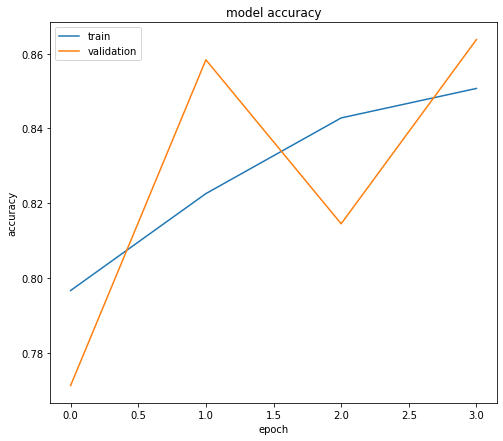

In [28]:
plt.figure(figsize=(8,7))
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

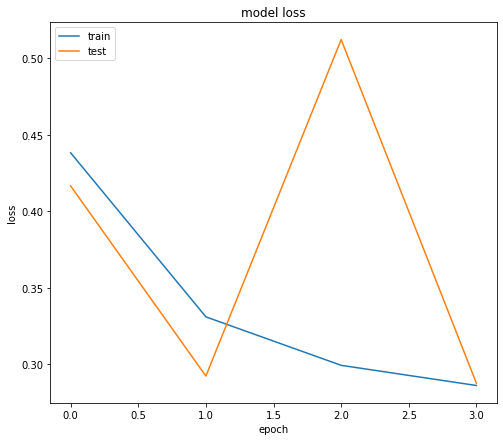

In [29]:
plt.figure(figsize=(8,7))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model achieves 85% accuracy

# Inferencing Step

In [ ]:
seq = tokenizer.texts_to_sequences(df['comments'])
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ["Effective","Ineffective"]
df_pred = pd.DataFrame(pred,columns=["Effective","Ineffective"])

df_pred